In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings


warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

ed_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [5]:
fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE",
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE",
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G",
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G",
             "GRADES_9_12_G", "GRADES_ALL_G"]

states = ed_df["STATE"].unique()

for state in states:
    ed_df.loc[ed_df["STATE"] == state, fill_list] = ed_df.loc[ed_df["STATE"] == state, fill_list].interpolate()

# we drop the null values after interpolation
ed_df.dropna(inplace=True)


#### 1: Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

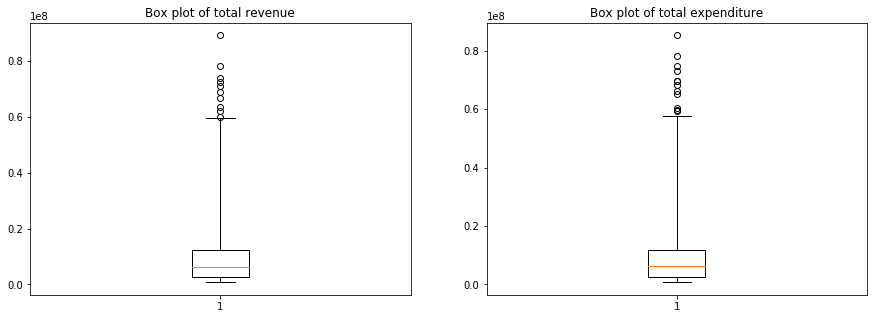

In [7]:

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(ed_df["TOTAL_REVENUE"], whis = 5)
plt.title("Box plot of total revenue")

plt.subplot(1,2,2)
plt.boxplot(ed_df["TOTAL_EXPENDITURE"], whis = 5)
plt.title("Box plot of total expenditure")
plt.show()

It does appear that these two categories contain outliers above the 4th quartile. 

#### 2: If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

Using the winsor method, set the ceiling of the outliers at the 95th percentile. Thusly two new data sets are created from the winsor method. 

In [8]:
from scipy.stats.mstats import winsorize

winsorized_revenue = winsorize(ed_df["TOTAL_REVENUE"], (0, 0.05))

winsorized_expenditure = winsorize(ed_df["TOTAL_EXPENDITURE"], (0, 0.05))

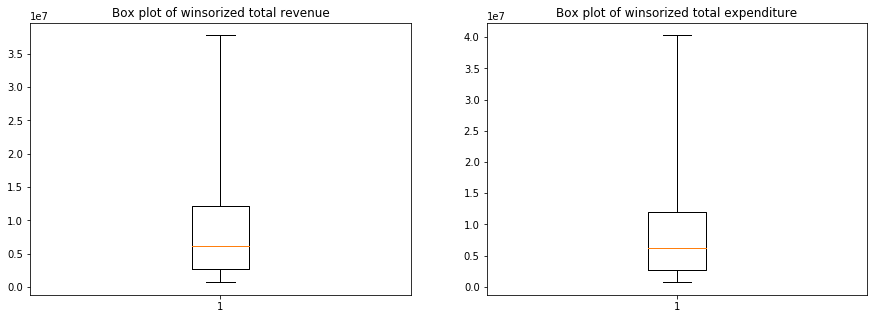

In [9]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(winsorized_revenue, whis = 5)
plt.title("Box plot of winsorized total revenue")

plt.subplot(1,2,2)
plt.boxplot(winsorized_expenditure, whis = 5)
plt.title("Box plot of winsorized total expenditure")
plt.show()

The box plots show that all outliers have been accounted for.

#### 3: Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

In [10]:
budget_deficit = ed_df.TOTAL_REVENUE - ed_df.TOTAL_EXPENDITURE

Text(0.5, 1.0, 'Box plot of budget deficit')

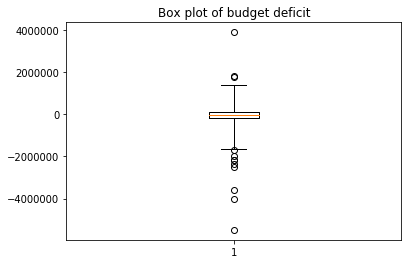

In [11]:
plt.boxplot(budget_deficit, whis = 5)
plt.title("Box plot of budget deficit")

Seeing that the deficit data contains outliers on either tail, apply a two-tailed winsor method.

Text(0.5, 1.0, 'Box plot of budget deficit')

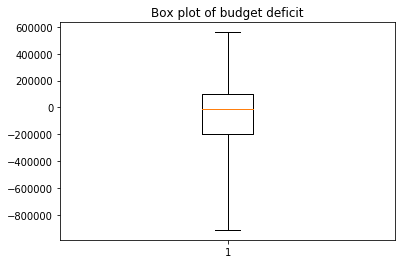

In [12]:
winsorized_budget = winsorize(budget_deficit, (0.05, 0.05))

plt.boxplot(winsorized_budget, whis = 5)
plt.title("Box plot of budget deficit")

Thusly we see either tail of the box plot free of outliers.

#### 4: Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

Text(0.5, 1.0, 'Box plot of budget deficit 2')

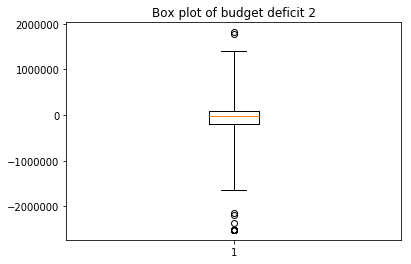

In [14]:
budget_deficit2 = winsorized_revenue - winsorized_expenditure

plt.boxplot(budget_deficit2, whis = 5)
plt.title("Box plot of budget deficit 2")

Again, we see outliers present on either tail of our deficit data, a two-tailed winsor is used to clean the data.

Text(0.5, 1.0, 'Box plot of budget deficit 2')

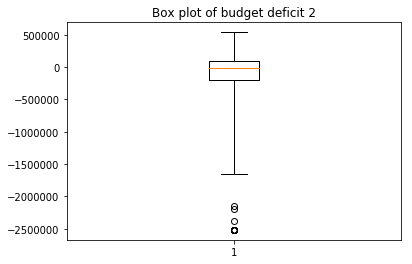

In [25]:
winsorized_budget2 = winsorize(budget_deficit2, (0.05, 0.05))

plt.boxplot(winsorized_budget2, whis = 5)
plt.title("Box plot of budget deficit 2")

As outliers are still present, we continue to use the winsor method until the data is outlier free. 

Text(0.5, 1.0, 'Box plot of budget deficit 2')

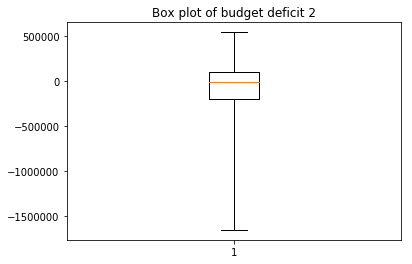

In [26]:
winsorized_budget3 = winsorize(winsorized_budget2, (0.06, 0))
plt.boxplot(winsorized_budget3, whis = 5)
plt.title("Box plot of budget deficit 2")

Finally we see a clean deficit data set.

#### 5: Compare some basic descriptive statistics of the budget variables you end up with in the third and the fourth questions. Do you see any differences?

In [27]:
pd.DataFrame({"original_budget": budget_deficit, "winsorized_budget1": winsorized_budget,
              "winsorized_budget2": winsorized_budget2}).describe()

,original_budget,winsorized_budget1,winsorized_budget2
count,4.660000e+02,466.000000,4.660000e+02
mean,-8.094882e+04,-58733.012876,-1.720532e+05
std,6.144222e+05,341300.816505,6.509561e+05
min,-5.487742e+06,-913765.000000,-2.518429e+06
25%,-1.965748e+05,-196574.750000,-2.047750e+05
50%,-8.872500e+03,-8872.500000,-1.282350e+04
75%,1.013948e+05,101394.750000,9.826300e+04
max,3.897129e+06,560511.000000,5.400550e+05


We see differences present throughout the description of both data variants;

The mean of the of the original and variants fluctuate considerably.

The median value from the first to second variant increases dramatically. 

Looking at the minimum values of the variant data, the first variant's minimum is -913765 and the second variant's minimum data point is -2518429, a difference of -1604664.

Each outlier elmination method had distinct effect on the data profile and statistical characteristics.


#### 6: If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the third question or the one in the fourth question?

It is best to retain as much data as possible throughout processing, I would imagine the method used in the third question is most useful since it uses the original data sets for expenditure and revenues. 